In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
matplotlib.use('Agg')
%matplotlib inline
import pandas as pd
pd.set_option('precision', 4)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

"""
    Helper function to read in results.
    Note: adapted from gather_metrics.py
"""
def gather_dir_metrics(directory, k, labels=['PriA-SSB AS'],
                       perc_vec=[0.001, 0.0015, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2],
                       n_tests_list=[100, 250, 500, 1000, 2500, 5000, 10000]):
    perc_vec = ['{:g}'.format(perc * 100) + ' %' for perc in perc_vec]
    n_tests_list = ['{:g}'.format(n_tests) for n_tests in n_tests_list]
    metric_names = ['ROC AUC', 'BEDROC AUC', 'PR auc.sklearn', 'PR auc.integral',
                    'PR auc.davis.goadrich'] + \
                    ['NEF_'+ str(s) for s in perc_vec] + \
                    ['EF_'+ str(s) for s in perc_vec] + \
                    ['Max_EF_'+ str(s) for s in perc_vec] + ['NEF AUC'] + \
                    ['n_hits_'+ str(s) for s in n_tests_list]
    folds = ['fold ' + str(i) for i in range(k)] + ['Folds Mean', 'Folds Median']
    fold_folders = ['train_metrics', 'val_metrics', 'test_metrics']
    model_names = os.listdir(directory)
    #gather all results in one gather_matrix                
    n_models = len(model_names)
    col_count = len(pd.read_csv(directory+'/'+model_names[0]+'/fold_0/test_metrics/metrics.csv').columns)
    col_count = (col_count-1)*len(metric_names)
    gather_matrix = np.zeros(shape=(n_models, 3, len(folds), col_count))+np.nan
    for m, m_name in zip(range(n_models), model_names):
        for f in range(k):
            fold_dir = directory+'/'+m_name+'/fold_'+str(f)+'/'
            for r, metrics_folder in zip(range(3), fold_folders):
                csv_file = fold_dir + metrics_folder+'/metrics.csv'
                if not os.path.isfile(csv_file):
                    continue     
                df = pd.read_csv(csv_file)  
                cols = [metric+' '+label for metric in metric_names for label in list(labels+['Mean', 'Median'])]
                
                df = df[(df.metric != 'NEF') & (df.metric != 'EF') & 
                        (df.metric != 'n_hits') &
                        (df.metric != 'Max_EF') & (~pd.isnull(df.metric))]
                df = df[df.columns[1:]]            
                results_arr = np.array(df, dtype=np.float)
                label_count = results_arr.shape[1]
                for results_r in range(results_arr.shape[0]):
                    gather_matrix[m, r, f, 
                        results_r*label_count:(results_r+1)*label_count] = results_arr[results_r,:] 
    #calculate means and medians
    for m, m_name in zip(range(n_models), model_names):
        for r, metrics_folder in zip(range(3), fold_folders):
            gather_matrix[m, r, k,:] = np.mean(gather_matrix[m, r, 0:k,:], axis=0)
            gather_matrix[m, r, k+1,:] = np.median(gather_matrix[m, r, 0:k,:], axis=0)
    
    #convert to pd.df with suitable namings
    cols[cols.index('NEF AUC Median')] = 'NEF AUC Random Mean'
    midx = pd.MultiIndex.from_product([model_names, fold_folders, folds],
                                      names=['model', 'set', 'fold'])
    gather_df = pd.DataFrame(data=gather_matrix.reshape(len(midx), col_count), 
                             index=midx,
                             columns=cols)
    return gather_df

In [2]:
#setup gather matrix
model_directory = './rfh_yscrambled/rfh_yscrambled_eval/'
gather_df = gather_dir_metrics(model_directory, 1)

col_indices = range(gather_df.shape[1])
col_indices = [i for i in col_indices if 'Mean' not in gather_df.columns[i] and 'Median' not in gather_df.columns[i]]
col_indices = [i for i in col_indices if 'PriA-SSB AS' in gather_df.columns[i]]
gather_df.columns = [col.replace('PriA-SSB AS', 'PriA-SSB prospective') for col in gather_df.columns]
metric_names = list(gather_df.columns.values[col_indices])
gather_df = gather_df[metric_names]
gather_df = gather_df.dropna(axis=0)
gather_df = gather_df.iloc[:,list(range(13)) + list(range(29,37))]

train_results = gather_df.xs(('train_metrics', 'fold 0'), level=('set', 'fold'))
prospective_results = gather_df.xs(('test_metrics', 'fold 0'), level=('set', 'fold'))

---
## Train Set Results
Tables show that the 100 Y-Scrambled models are trained well on the training set.

In [3]:
train_results

,ROC AUC PriA-SSB prospective,BEDROC AUC PriA-SSB prospective,PR auc.sklearn PriA-SSB prospective,PR auc.integral PriA-SSB prospective,PR auc.davis.goadrich PriA-SSB prospective,NEF_0.1 % PriA-SSB prospective,NEF_0.15 % PriA-SSB prospective,NEF_0.5 % PriA-SSB prospective,NEF_1 % PriA-SSB prospective,NEF_2 % PriA-SSB prospective,NEF_5 % PriA-SSB prospective,NEF_10 % PriA-SSB prospective,NEF_20 % PriA-SSB prospective,NEF AUC PriA-SSB prospective,n_hits_100 PriA-SSB prospective,n_hits_250 PriA-SSB prospective,n_hits_500 PriA-SSB prospective,n_hits_1000 PriA-SSB prospective,n_hits_2500 PriA-SSB prospective,n_hits_5000 PriA-SSB prospective,n_hits_10000 PriA-SSB prospective
model,,,,,,,,,,,,,,,,,,,,,
process_0,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_1,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_10,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_11,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_12,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_13,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_14,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_15,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0
process_16,1.0,0.9946,1.0000,1.0000,1.0000,1.0000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995,79.0,79.0,79.0,79.0,79.0,79.0,79.0


---
## Prospective Set Results
Tables show that the 100 Y-Scrambled models do poorly on the prospective set.

In [4]:
prospective_results

,ROC AUC PriA-SSB prospective,BEDROC AUC PriA-SSB prospective,PR auc.sklearn PriA-SSB prospective,PR auc.integral PriA-SSB prospective,PR auc.davis.goadrich PriA-SSB prospective,NEF_0.1 % PriA-SSB prospective,NEF_0.15 % PriA-SSB prospective,NEF_0.5 % PriA-SSB prospective,NEF_1 % PriA-SSB prospective,NEF_2 % PriA-SSB prospective,NEF_5 % PriA-SSB prospective,NEF_10 % PriA-SSB prospective,NEF_20 % PriA-SSB prospective,NEF AUC PriA-SSB prospective,n_hits_100 PriA-SSB prospective,n_hits_250 PriA-SSB prospective,n_hits_500 PriA-SSB prospective,n_hits_1000 PriA-SSB prospective,n_hits_2500 PriA-SSB prospective,n_hits_5000 PriA-SSB prospective,n_hits_10000 PriA-SSB prospective
model,,,,,,,,,,,,,,,,,,,,,
process_0,0.4923,0.1224,0.0026,0.0026,0.0026,0.0000,0.0000,0.0000,0.0000,0.0556,0.0741,0.1481,0.2037,0.1269,0.0,1.0,3.0,4.0,9.0,11.0,23.0
process_1,0.4254,0.0705,0.0024,0.0025,0.0025,0.0000,0.0303,0.0370,0.0370,0.0370,0.0556,0.0556,0.0926,0.0613,1.0,2.0,2.0,3.0,3.0,7.0,18.0
process_10,0.6289,0.1590,0.0036,0.0036,0.0036,0.0000,0.0000,0.0000,0.0000,0.0370,0.0741,0.1667,0.3148,0.1597,0.0,0.0,2.0,4.0,9.0,17.0,34.0
process_11,0.5129,0.0969,0.0024,0.0024,0.0024,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370,0.1111,0.2037,0.1000,0.0,0.0,0.0,2.0,6.0,13.0,26.0
process_12,0.4391,0.1002,0.0022,0.0022,0.0022,0.0000,0.0000,0.0000,0.0000,0.0185,0.0556,0.1111,0.1852,0.1009,0.0,0.0,1.0,3.0,6.0,11.0,20.0
process_13,0.5404,0.1289,0.0028,0.0029,0.0029,0.0000,0.0000,0.0000,0.0185,0.0556,0.0741,0.1296,0.2593,0.1345,0.0,1.0,3.0,4.0,8.0,14.0,27.0
process_14,0.5479,0.1140,0.0027,0.0027,0.0027,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370,0.0926,0.3148,0.1208,0.0,0.0,0.0,2.0,6.0,18.0,27.0
process_15,0.4412,0.1102,0.0023,0.0023,0.0023,0.0000,0.0000,0.0000,0.0000,0.0000,0.0741,0.1296,0.2222,0.1190,0.0,0.0,0.0,3.0,8.0,14.0,20.0
process_16,0.5268,0.0906,0.0025,0.0025,0.0025,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370,0.0741,0.2037,0.0861,0.0,0.0,0.0,2.0,4.0,12.0,29.0


---
## Prospective n_hits_250  hits distribution
Distribution of the n_hits_250 for the 100 models showcase that they perform much worse than the baseline.

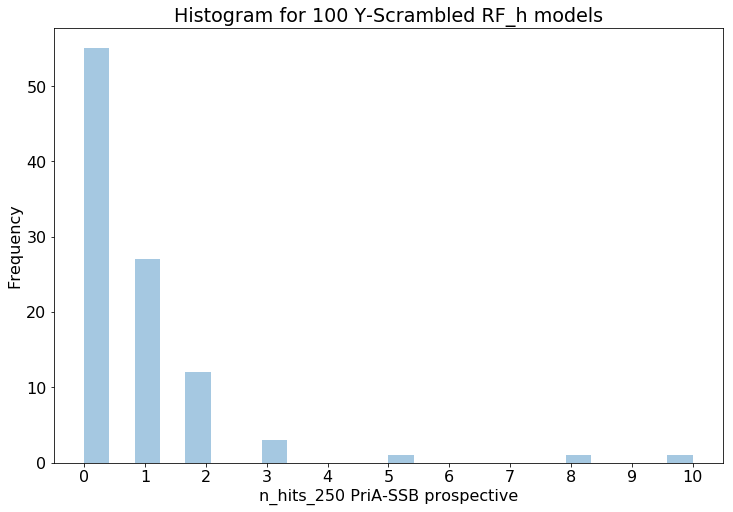

In [5]:
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(12, 8))
ax = sns.distplot(prospective_results['n_hits_250 PriA-SSB prospective'], kde=False)
plt.ylabel('Frequency'); plt.title('Histogram for 100 Y-Scrambled RF_h models');ax.set_xticks(range(11));